In [124]:
# Sweep dataset sizes from 1..d**2 and compute in-sample GPR MSE
%load_ext autoreload
%autoreload 2
import torch
from GPKit import GPR_kernel, GPR, gpr_dot_product_explicit

# Config
d = 5  # input dimension
noise_std = 0.05
alpha = 1e-5  # GPKit regularizer 'a'

# Device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Generate a fixed ground-truth linear model and a pool of data up to d**2
max_n = 2 * d ** 2
w_true = torch.randn(d, 1, device=device)
X_all = torch.randn(max_n, d, device=device)
y_clean_all = (X_all[:,0]).squeeze()
y_all = y_clean_all 

mses = []
for n in range(1, max_n + 1):
    X = X_all[:n]
    y = y_all[:n]
    X_rand = torch.randn(max_n, d, device=device)
    y_rand_all = (X_rand[:,0]).squeeze()
    y_pred = gpr_dot_product_explicit(X, y, X, 1.0)
   
    mse = 0.5 * torch.mean((y_pred - y) ** 2).item()
    mses.append(mse)

print(f"Computed {len(mses)} MSE values for sizes 1..{max_n}")
print("First 10:", [round(v, 6) for v in mses[:10]])
print("Last 10:", [round(v, 6) for v in mses[-10:]])
mses


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Computed 50 MSE values for sizes 1..50
First 10: [0.003026, 0.002084, 0.071449, 0.052077, 0.047236, 0.042784, 0.060768, 0.059707, 0.057244, 0.055061]
Last 10: [0.006059, 0.005847, 0.005429, 0.005256, 0.005134, 0.004985, 0.004872, 0.004764, 0.004661, 0.004537]


[0.003025946905836463,
 0.0020843450911343098,
 0.07144896686077118,
 0.052076879888772964,
 0.047235939651727676,
 0.04278380796313286,
 0.06076817959547043,
 0.059706948697566986,
 0.057243842631578445,
 0.05506064370274544,
 0.04934881255030632,
 0.041520796716213226,
 0.038983672857284546,
 0.035906821489334106,
 0.03336352854967117,
 0.031026508659124374,
 0.026434466242790222,
 0.02446804940700531,
 0.023030297830700874,
 0.02194386161863804,
 0.019817356020212173,
 0.01647680625319481,
 0.015760667622089386,
 0.014959747903048992,
 0.014355618506669998,
 0.01379870530217886,
 0.012846103869378567,
 0.01235159207135439,
 0.011596852913498878,
 0.010946301743388176,
 0.01050123106688261,
 0.010140614584088326,
 0.009833415038883686,
 0.0091321412473917,
 0.008864316157996655,
 0.008241071365773678,
 0.007260322105139494,
 0.006918861530721188,
 0.006732548121362925,
 0.006443467922508717,
 0.006059246603399515,
 0.0058473446406424046,
 0.005428955424576998,
 0.005256290081888437,


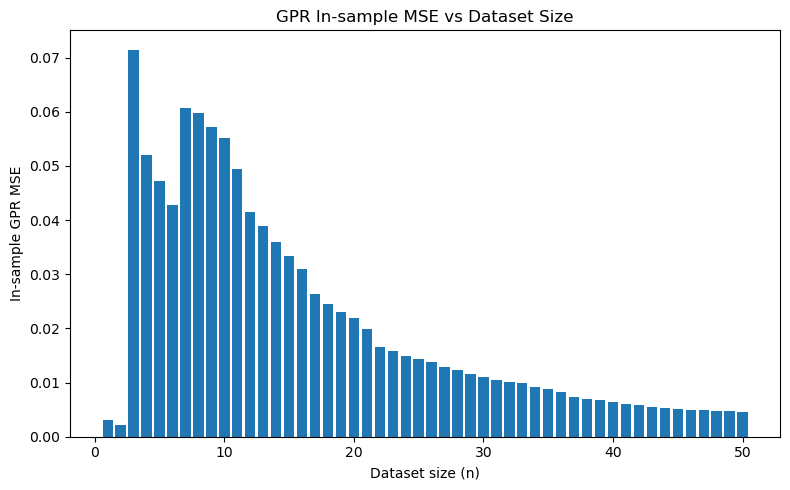

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(mses) + 1), mses)
plt.xlabel("Dataset size (n)")
plt.ylabel("In-sample GPR MSE")
plt.title("GPR In-sample MSE vs Dataset Size")
plt.tight_layout()
plt.show()


In [119]:
X_all.shape

torch.Size([25, 5])

In [ ]:
import torch
from pathlib import Path
current_dir = Path().resolve()
super_dir = current_dir.parent

import numpy as np
import matplotlib.pyplot as plt
import os
import torch.optim as optim
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import Function
from torch.nn.parameter import Parameter
from torch import autograd
import sys
from opt_einsum import contract, contract_path

sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

class FCN_2_Ensemble(nn.Module):
    def __init__(self, d, n1, s2W, s2A, ensembles=1, init_seed=None):
        super().__init__()
        if init_seed is None:
            torch.manual_seed(INIT_SEED)

        self.arch = [d, n1]
        self.d = d
        self.n1 = n1
        self.W0 = nn.Parameter(torch.normal(mean=0.0,
            std=torch.full((ensembles, n1, d), s2W ** 0.5)).to(DEVICE),
            requires_grad=True)
        self.A = nn.Parameter(torch.normal(
            mean=0.0,
            std=torch.full((ensembles, n1), s2A ** 0.5)).to(DEVICE),
            requires_grad=True)

    def forward(self, X):
        Xp = X.squeeze()
        return contract(
            'ik,ikl,ul->ui',
            self.A, self.W0, Xp,
            backend='torch'
        )

    def h_activation(self, X):
        return contract(
            'ikl,ul->uik',
            self.W0, X,
            backend='torch'
        )

class LangevinSimple2(optim.Optimizer):
    def __init__(self, model: nn.Module, learning_rate, weight_decay_1, weight_decay_2, temperature):

        defaults = {
            'learning_rate': learning_rate,
            'weight_decay': 0.,
            'temperature': temperature
        }

        # a list of dictionaries which gives a simple way of breaking a model’s parameters into separate components   for optimization.
        groups = [{'params' : model.W0, # input to hidden Conv
                   'learning_rate' : learning_rate,
                   'weight_decay' : weight_decay_1,
                   'temperature' : temperature},
                   {'params' : model.A, # hidden to linear readout
                    'learning_rate' : learning_rate,
                    'weight_decay'  : weight_decay_2,
                    'temperature' : temperature},
                 ]
        super(LangevinSimple2, self).__init__(groups, defaults)

    @torch.no_grad()
    def step(self, closure=None):

        for group in self.param_groups:

            learning_rate = group['learning_rate']
            weight_decay = group['weight_decay']
            temperature = group['temperature']
            for parameter in group['params']:
                eta = torch.randn_like(parameter)
                d_p = eta * (2*learning_rate*temperature)**0.5
                d_p = d_p.to(DEVICE)
                d_p.add_(parameter, alpha=-learning_rate*weight_decay)
                d_p.add_(parameter.grad, alpha=-0.5*learning_rate)
                parameter.add_(d_p)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate random unit Gaussian dataset
P = 20  # number of samples
d = 4  # input dimension
N = 10
chi_param = 1.0
ens = 1
lr0 = 0.001
temperature = 1.0
wd_input = d * temperature
wd_output = chi_param * N * temperature
epochs = 10000
DEVICE = torch.device('cuda:1')
X = torch.randn(N, 1,d).to(DEVICE)
# Generate linear features: y = w^T x + noise
true_w = torch.randn(d, 1).to(DEVICE)
y = X @ true_w


# Store train losses for each dataset size and each run
all_train_losses = np.zeros(P)  # [dataset_size]


torch.manual_seed(73)
for p in range(2, P+1):  # dataset sizes 1 to 8
    print(f'Running for dataset size: {p}')
    X_p = X[:p,:,:]
    y_p = y[:p,:,:]
    print(X_p.shape)
    lr = lr0/p

    model = FCN_2_Ensemble(
            d,
            N,
            1.0/(N*chi_param),
            1.0/d,
    ensembles=ens).to(DEVICE)
    losses = []

    for epoch in range(epochs):
        optimizer = LangevinSimple2(model, lr, wd_input, wd_output, temperature)

        optimizer.zero_grad()
        y_pred = model(X_p)
        loss = 0.5 * torch.sum((y_pred - y_p) ** 2)
        loss.backward()
        optimizer.step()

    all_train_losses[p-2] = loss.item()
plt.figure(figsize=(10, 6))
plt.bar(np.arange(2, P+2), all_train_losses/np.arange(2,P+2))
plt.xlabel("Dataset size")
plt.ylabel("Train MSE Loss")
plt.title("Train Loss vs Epoch for Different Dataset Sizes")
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()






Running for dataset size: 2
torch.Size([2, 1, 4])
Running for dataset size: 3
torch.Size([3, 1, 4])
Running for dataset size: 4
torch.Size([4, 1, 4])
Running for dataset size: 5
torch.Size([5, 1, 4])
Running for dataset size: 6
torch.Size([6, 1, 4])
Running for dataset size: 7
torch.Size([7, 1, 4])
Running for dataset size: 8
torch.Size([8, 1, 4])
Running for dataset size: 9
torch.Size([9, 1, 4])
Running for dataset size: 10
torch.Size([10, 1, 4])
Running for dataset size: 11
torch.Size([10, 1, 4])
Running for dataset size: 12
torch.Size([10, 1, 4])
Running for dataset size: 13
torch.Size([10, 1, 4])
Running for dataset size: 14
torch.Size([10, 1, 4])
Running for dataset size: 15
torch.Size([10, 1, 4])
Running for dataset size: 16
torch.Size([10, 1, 4])
Running for dataset size: 17
torch.Size([10, 1, 4])
Running for dataset size: 18
torch.Size([10, 1, 4])
Running for dataset size: 19
torch.Size([10, 1, 4])
Running for dataset size: 20
torch.Size([10, 1, 4])


In [54]:
X.squeeze().shape

torch.Size([10, 4])

In [55]:

model = FCN_2_Ensemble(
        d,
        N,
        1.0/(N*chi_param),
        1.0/d,
ensembles=ens).to(DEVICE)
model(X[:4,:,:])

tensor([[-0.4553],
        [-1.2210],
        [ 0.3407],
        [ 0.1880]], device='cuda:1', grad_fn=<PermuteBackward0>)

In [62]:
[i for i in range(2,P+1)]


[2, 3, 4, 5, 6, 7, 8]

In [63]:

torch.manual_seed(73)
for p in range(2, P+1):  # dataset sizes 1 to 8
    print(f'Running for dataset size: {p}')
    X_p = X[:p,:,:]
    y_p = y[:p,:,:]
    print(X_p.shape)
    lr = lr0/p

    model = FCN_2_Ensemble(
            d,
            N,
            1.0/(N*chi_param),
            1.0/d,
    ensembles=ens).to(DEVICE)
    losses = []

    for epoch in range(epochs):
        optimizer = LangevinSimple2(model, lr, wd_input, wd_output, temperature)

        optimizer.zero_grad()
        y_pred = model(X_p)
        loss = 0.5 * torch.sum((y_pred - y_p) ** 2)
        loss.backward()
        optimizer.step()

    all_train_losses[p-2] = loss.item()





Running for dataset size: 2
torch.Size([2, 1, 4])
Running for dataset size: 3
torch.Size([3, 1, 4])
Running for dataset size: 4
torch.Size([4, 1, 4])
Running for dataset size: 5
torch.Size([5, 1, 4])
Running for dataset size: 6
torch.Size([6, 1, 4])
Running for dataset size: 7
torch.Size([7, 1, 4])
Running for dataset size: 8
torch.Size([8, 1, 4])


In [71]:
all_train_losses.shape

(20,)

In [72]:
np.arange(2,P+2).shape

(20,)

/tmp/ipykernel_3411302/425491170.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


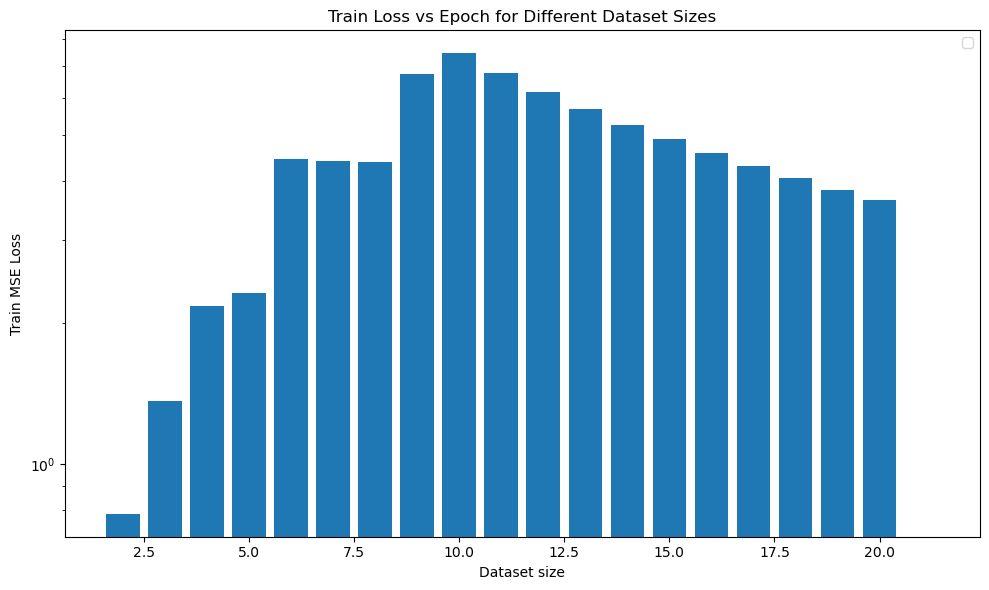

In [ ]:
# Plotting mean and std of train loss across runs for each dataset size


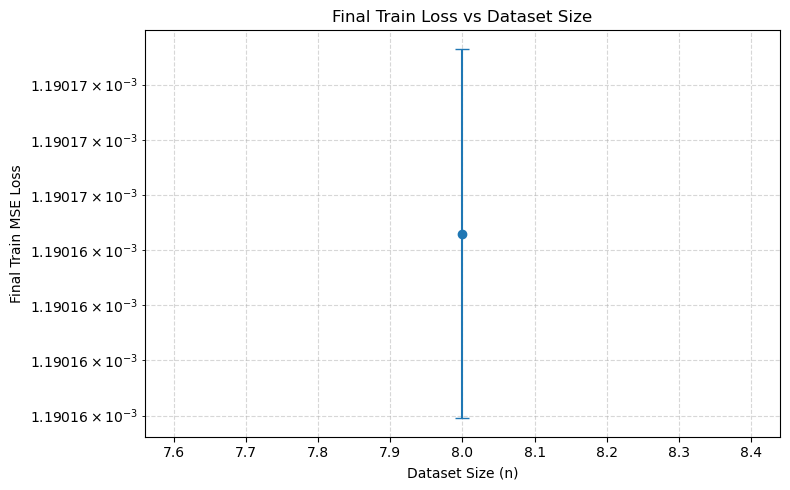

In [8]:
# Plot average and std of the final train loss for each dataset size
final_train_losses = all_train_losses[:, :, -1]  # shape: (dataset_size, run)
mean_final_loss = final_train_losses.mean(axis=1)
std_final_loss = final_train_losses.std(axis=1)

plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(1, N+1), mean_final_loss, yerr=std_final_loss, fmt='o-', capsize=5)
plt.xlabel("Dataset Size (n)")
plt.ylabel("Final Train MSE Loss")
plt.title("Final Train Loss vs Dataset Size")
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()
